# **Анализ показа рекламы пользователям мобильной игры**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from IPython.core.pylabtools import figsize

In [ ]:
from ast import literal_eval
from io import StringIO


In [ ]:
import plotly.express as px
import plotly.figure_factory as ff

Загрузим данные

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/us events ad_revenue filtered 03.02-07.02.csv')
df.head()

,profile_id,os_version,device_manufacturer,device_model,device_type,device_locale,event_name,event_json,event_datetime,event_timestamp,event_receive_datetime,event_receive_timestamp,connection_type,operator_name,country_iso_code,city
0,JLjpGzDHBQm,11,Samsung,Galaxy Tab S6,tablet,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-04 20:02:28,1643994148,2022-02-06 17:58:19,1644159499,wifi,NaN,US,Norwalk
1,JLjpGzDHBQm,11,Samsung,Galaxy Tab S6,tablet,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-04 20:02:45,1643994165,2022-02-06 17:58:19,1644159499,wifi,NaN,US,Norwalk
2,JLkVacrzHY6,11,Google,Pixel 2,phone,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-05 17:53:05,1644072785,2022-02-06 16:59:29,1644155969,wifi,Verizon,US,Charlotte
3,JMC6wG3cX0f,10,Samsung,Galaxy S9,phone,en_US,c_ad_revenue,"{""ad_type"":""int"",""placement"":""next_level"",""vie...",2022-02-06 17:09:01,1644156541,2022-02-06 17:09:24,1644156564,wifi,T-Mobile,US,Cocoa
4,JLzWWTJfi1b,10,Samsung,Galaxy S9,phone,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-06 17:15:38,1644156938,2022-02-06 17:16:16,1644156976,cell,Verizon,US,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 860079 entries, 0 to 860078
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   profile_id               860065 non-null  object
 1   os_version               860079 non-null  object
 2   device_manufacturer      860079 non-null  object
 3   device_model             860079 non-null  object
 4   device_type              860079 non-null  object
 5   device_locale            860079 non-null  object
 6   event_name               860079 non-null  object
 7   event_json               860079 non-null  object
 8   event_datetime           860079 non-null  object
 9   event_timestamp          860079 non-null  int64 
 10  event_receive_datetime   860079 non-null  object
 11  event_receive_timestamp  860079 non-null  int64 
 12  connection_type          860079 non-null  object
 13  operator_name            841200 non-null  object
 14  country_iso_code    

Распакуем сведения из столбца 'event_json' в новый датафрейм

In [ ]:
event_json = pd.DataFrame(df['event_json'])

In [ ]:
event_json['event_json'] = event_json['event_json'].apply(literal_eval)

In [ ]:
def unpack_column(df,column):
 
    # Собираем set со всеми ключами словарей в колонке salary
    new_cols=set()
    for i in df.index:
        sal = df.iloc[i][column]
        if sal is not None:
            kys = set(sal.keys())
            new_cols = new_cols | kys
 
    # Создаем словарь, записываем в него ключи из нашего сета. 
    # Значениями будут постые списки. Потом будем заполнять их в цикле, чтобы добавить колонки в df. 
    col={}
 
    for k in new_cols:
        col[k]=[]
 
 
    for i in df.index:
        sal = df.iloc[i][column]
        if sal is not None:
            for k in new_cols:
                if k in sal:
                    col[k].append(sal[k])
                else:
                    col[k].append(None)
        else:
            for k in new_cols:
                col[k].append(None)
    
    # добавляем колокни в датафрейм
    for k in new_cols:
        df[k]=col[k]
    # Удаляем исходную колонку
    del df[column]

In [ ]:
unpack_column(event_json,'event_json')

Объединим два датафрейма

In [ ]:
df_united = pd.concat([df, event_json[['ad_type', 'revenue', 'ecpm_sma', 'network_name', 'ads_ltv']]], join='outer', axis=1)

Отфильтруем данные по форматам рекламы и сгруппируем по пользователям, городам и версиям ОС

In [ ]:
df_banner = df_united.loc[df_united['ad_type']=='banner'].reset_index(drop=True)
df_int = df_united.loc[df_united['ad_type']=='int'].reset_index(drop=True)
df_rv = df_united.loc[df_united['ad_type']=='rv'].reset_index(drop=True)

In [ ]:
df_banner_profile = df_banner.groupby(by='profile_id')[['ecpm_sma']].mean()
df_banner_city = df_banner.groupby(by='city')[['ecpm_sma']].mean()
df_banner_os = df_banner.groupby(by='os_version')[['ecpm_sma']].mean()
df_banner_revenue_city = df_banner.groupby(by='city')[['revenue']].sum()
df_banner_revenue_os = df_banner.groupby(by='os_version')[['revenue']].sum()

In [ ]:
df_int_profile = df_int.groupby(by='profile_id')[['ecpm_sma']].mean()
df_int_city = df_int.groupby(by='city')[['ecpm_sma']].mean()
df_int_os = df_int.groupby(by='os_version')[['ecpm_sma']].mean()
df_int_revenue_city = df_int.groupby(by='city')[['revenue']].sum()
df_int_revenue_os = df_int.groupby(by='os_version')[['revenue']].sum()

In [ ]:
df_rv_profile = df_rv.groupby(by='profile_id')[['ecpm_sma']].mean()
df_rv_city = df_rv.groupby(by='city')[['ecpm_sma']].mean()
df_rv_os = df_rv.groupby(by='os_version')[['ecpm_sma']].mean()
df_rv_revenue_city = df_rv.groupby(by='city')[['revenue']].sum()
df_rv_revenue_os = df_rv.groupby(by='os_version')[['revenue']].sum()

Построим распределение средних eCPM пользователей

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


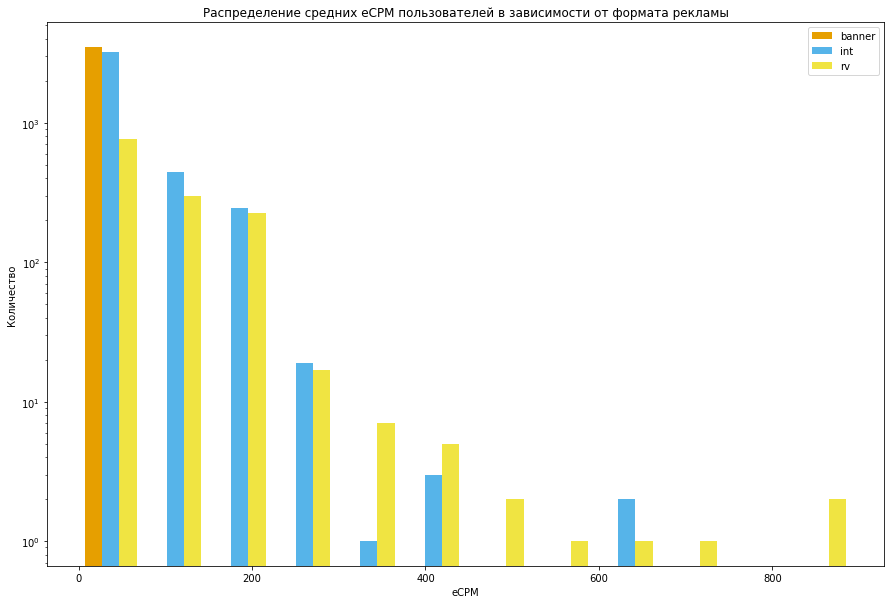

In [ ]:
figsize(15, 10)
colors = ['#E69F00', '#56B4E9', '#F0E442']
names = ['banner', 'int', 'rv']

plt.hist([df_banner_profile, df_int_profile, df_rv_profile], bins = int(180/15),
         color = colors, label=names, log=True)

plt.legend()
plt.xlabel('eCPM')
plt.ylabel('Количество')
plt.title('Распределение средних eCPM пользователей в зависимости от формата рекламы')
plt.show()

Средние eCPM по городам и версиям ОС

In [ ]:
fig = px.line(
    df_banner_city,
    x=df_banner_city.index, 
    y='ecpm_sma', 
    title='Средние eCPM от рекламы в формате "banner" по городам'
    )
fig.show()

fig = px.line(
    df_int_city,
    x=df_int_city.index, 
    y='ecpm_sma', 
    title='Средние eCPM от рекламы в формате "int" по городам'
    )
fig.show()

fig = px.line(
    df_rv_city,
    x=df_rv_city.index, 
    y='ecpm_sma', 
    title='Средние eCPM от рекламы в формате "rv" по городам'
    )
fig.show()

In [ ]:
fig = px.line(
    df_banner_os,
    x=df_banner_os.index, 
    y='ecpm_sma', 
    title='Средние eCPM от рекламы в формате "banner" по версиям ОС'
    )
fig.show()

fig = px.line(
    df_int_os,
    x=df_int_os.index, 
    y='ecpm_sma', 
    title='Средние eCPM от рекламы в формате "int" по версиям ОС'
    )
fig.show()

fig = px.line(
    df_rv_os,
    x=df_rv_os.index, 
    y='ecpm_sma', 
    title='Средние eCPM от рекламы в формате "rv" по версиям ОС'
    )
fig.show()

Суммарные доходы от рекламы по городам и версиям ОС

In [ ]:
fig = px.line(
    df_banner_revenue_city,
    x=df_banner_revenue_city.index, 
    y='revenue', 
    title='Распределение доходов от рекламы в формате "banner" по городам'
    )
fig.show()

fig = px.line(
    df_int_revenue_city,
    x=df_int_revenue_city.index, 
    y='revenue', 
    title='Распределение доходов от рекламы в формате "int" по городам'
    )
fig.show()

fig = px.line(
    df_rv_revenue_city,
    x=df_rv_revenue_city.index, 
    y='revenue', 
    title='Распределение доходов от рекламы в формате "rv" по городам'
    )
fig.show()

In [ ]:
fig = px.line(
    df_banner_revenue_os,
    x=df_banner_revenue_os.index, 
    y='revenue', 
    title='Распределение доходов от рекламы в формате "banner" по версиям ОС'
    )
fig.show()

fig = px.line(
    df_int_revenue_os,
    x=df_int_revenue_os.index, 
    y='revenue', 
    title='Распределение доходов от рекламы в формате "int" по версиям ОС'
    )
fig.show()

fig = px.line(
    df_rv_revenue_os,
    x=df_rv_revenue_os.index, 
    y='revenue', 
    title='Распределение доходов от рекламы в формате "rv" по версиям ОС'
    )
fig.show()

**Выводы по итогам анализа**


Формат рекламы "banner":
*   самое большо количество показов;  
*   низкий средний eCPM пользователей;

*   в разбивке по городам средний eCPM в пределах от 0 до 5, **в целом отмечается высокий средний eCPM в небольших городах по всем форматам ракламы;**
*   в разбивке по версии ОС более весокий средний eCPM у более свежих версий ОС;

*   суммарные доходы сильно колеблются ориентировочно пропорционально общему количеству населения городов;
*   суммарные доходы выше у последних версий ОС с пиком у ОС "12", что объясняется тем, что устройства с ОС "12" составляют чуть меньше половины всех наблюдений.







Формат рекламы "int":

*   среднее количество показов;  
*   средний eCPM пользователей выше "banner", но ниже чем у "rv";

*   в разбивке по городам средний eCPM в пределах от 0 до 200, **в целом отмечается высокий средний eCPM в небольших городах по всем форматам ракламы;**
*   в разбивке по версии ОС более весокий средний eCPM у версии ОС "12", **в тоже время отмечается аномально высокий средний eCPM у версии ОС "7.0";**

*   суммарные доходы сильно колеблются ориентировочно пропорционально общему количеству населения городов;
*   суммарные доходы выше у последних версий ОС с пиком у ОС "12", что объясняется тем, что устройства с ОС "12" составляют чуть меньше половины всех наблюдений.

Формат рекламы "rv":

*   наименьшее количество показов;  
*   средний eCPM пользователей самый высокий, но учитывая нименьшее количество наблюдений может быть подвержен выбросам;

*   в разбивке по городам средний eCPM в пределах от 0 до 250, **в целом отмечается высокий средний eCPM в небольших городах по всем форматам ракламы;**
*   в разбивке по версии ОС более весокий средний eCPM у версии ОС "12", **в тоже время отмечается аномально высокий средний eCPM у версии ОС "7.0";**

*   суммарные доходы сильно колеблются ориентировочно пропорционально общему количеству населения городов;
*   суммарные доходы выше у последних версий ОС с пиком у ОС "12", что объясняется тем, что устройства с ОС "12" составляют чуть меньше половины всех наблюдений.

**Дополнительно**

Процент доходов, который содержит информацию о городе пользователя

In [ ]:
result = (df_united['city'].count()) * 100 / (df_united['revenue'].count())

In [ ]:
print(f'Процент доходов с информацией о городе составляет: %.1f' % result, '%')

Процент доходов с информацией о городе составляет: 62.4 %


Зависимость eCPM от времени дня

In [ ]:
df_united['event_datetime'] = pd.to_datetime(df_united['event_datetime'])
df_united['hour'] = df_united.event_datetime.dt.hour
df_datetime = df_united.groupby(by='hour')[['ecpm_sma']].sum()

In [ ]:
fig = px.line(
    df_datetime,
    x=df_datetime.index, 
    y='ecpm_sma', 
    title='Средние eCPM в завимости от времени дня'
    )
fig.show()

Пик eCPM приходится на 5 часов утра, днем существенное снижение и рост после 15 часов.

Средние значения eCPM в зависимости от рекламной сети и суммарные доходы в зависимости от рекламной сети

In [ ]:
df_network = df_united.groupby(by='network_name').agg({
    'ecpm_sma':'mean',
    'revenue': 'sum'
    })
fig = px.bar(
    df_network,
    x=df_network.index, 
    y='ecpm_sma', 
    title='Средние значения eCPM в зависимости от рекламной сети'
    )
fig.show()

fig = px.bar(
    df_network,
    x=df_network.index, 
    y='revenue', 
    title='Суммарные доходы в зависимости от рекламной сети'
    )
fig.show()

Рекламная сеть с самым высоким средним eCPM 'AppLovin'. Лидер по суммарному доходу 'Google AdMod'